# Longitudinal RSA Analysis: Bilateral vs Unilateral Visual Categories
## Streamlined Version - VOTC Resection Study

In [10]:
# CELL 1: Setup & Configuration
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass, label
import pandas as pd
from scipy.stats import pearsonr, linregress, ttest_ind
from sklearn.manifold import MDS
from scipy.spatial import procrustes
import seaborn as sns
from matplotlib.patches import Circle
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

# Configuration
BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
df = pd.read_csv(CSV_FILE)
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

COPE_MAP = {
    'face': 1,
    'word': 12, 
    'object': 3,
    'house': 2
}

def load_subjects_by_group(group_filter=None, patient_only=True):
    """Load subjects dynamically from CSV"""
    filtered_df = df.copy()
    
    if patient_only is True:
        filtered_df = filtered_df[filtered_df['patient'] == 1]
    elif patient_only is False:
        filtered_df = filtered_df[filtered_df['patient'] == 0]
    
    if group_filter:
        if isinstance(group_filter, str):
            group_filter = [group_filter]
        filtered_df = filtered_df[filtered_df['group'].isin(group_filter)]
    
    subjects = {}
    
    for _, row in filtered_df.iterrows():
        subject_id = row['sub']
        
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
            
        sessions = []
        for ses_dir in subj_dir.glob('ses-*'):
            if ses_dir.is_dir():
                sessions.append(ses_dir.name.replace('ses-', ''))
        
        if not sessions:
            continue
            
        sessions = sorted(sessions, key=lambda x: int(x))
        start_session = SESSION_START.get(subject_id, 1)
        available_sessions = [s for s in sessions if int(s) >= start_session]
        
        if not available_sessions:
            continue
            
        hemisphere_full = row.get('intact_hemi', 'left') if pd.notna(row.get('intact_hemi', None)) else 'left'
        hemisphere = 'l' if hemisphere_full == 'left' else 'r'
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': available_sessions,
            'hemi': hemisphere,
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control',
            'age_1': row['age_1'] if pd.notna(row['age_1']) else None
        }
    
    return subjects

# Load all subjects
ALL_PATIENTS = load_subjects_by_group(group_filter=None, patient_only=True)
ALL_CONTROLS = load_subjects_by_group(group_filter=None, patient_only=False)
ANALYSIS_SUBJECTS = {**ALL_PATIENTS, **ALL_CONTROLS}

print(f"RSA Analysis - {len(ANALYSIS_SUBJECTS)} subjects loaded")
print(f"Patients: {len(ALL_PATIENTS)}, Controls: {len(ALL_CONTROLS)}")

RSA Analysis - 25 subjects loaded
Patients: 16, Controls: 9


In [11]:
# CELL 2: Extract Functional ROIs
def extract_rois(subject_id, subjects_dict, threshold_z=2.3):
    """Extract functional cluster ROIs across all sessions"""
    
    if subject_id not in subjects_dict:
        print(f"❌ {subject_id} not in analysis group")
        return {}
        
    info = subjects_dict[subject_id]
    code = info['code']
    hemi = info['hemi']
    sessions = info['sessions']
    first_session = sessions[0]
    
    print(f"\n{code} - Extracting ROIs [{info['group']} {info['patient_status']}]")
    
    all_results = {}
    
    for category, cope_num in COPE_MAP.items():
        all_results[category] = {}
        
        # Load category-specific mask
        mask_file = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not mask_file.exists():
            print(f"  ⚠️  {category}: mask not found")
            continue
        
        mask = nib.load(mask_file).get_fdata() > 0
        affine = nib.load(mask_file).affine
        
        # Process each session
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            
            zstat_file = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            # Load functional activation
            zstat = nib.load(cope_file).get_fdata()
            suprathresh = (zstat > threshold_z) & mask
            
            if suprathresh.sum() < 50:
                continue
            
            # Find largest cluster
            labeled, n_clusters = label(suprathresh)
            if n_clusters == 0:
                continue
                
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            roi_mask = (labeled == largest_idx)
            
            # Extract metrics
            peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
            peak_z = zstat[peak_idx]
            centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
            
            # Store results
            all_results[category][session] = {
                'n_voxels': cluster_sizes[largest_idx - 1],
                'peak_z': peak_z,
                'centroid': centroid,
                'roi_mask': roi_mask
            }
    
    return all_results

# Extract ROIs for all subjects
print("EXTRACTING FUNCTIONAL ROIs")
print("="*50)

functional_rois = {}
for subject_id in ANALYSIS_SUBJECTS.keys():
    try:
        functional_rois[subject_id] = extract_rois(subject_id, ANALYSIS_SUBJECTS, threshold_z=2.3)
    except Exception as e:
        print(f"❌ {subject_id} failed: {e}")
        functional_rois[subject_id] = {}

print(f"\n✓ ROI extraction complete for {len(functional_rois)} subjects!")

EXTRACTING FUNCTIONAL ROIs

OTC004 - Extracting ROIs [OTC patient]

nonOTC007 - Extracting ROIs [nonOTC patient]

OTC008 - Extracting ROIs [OTC patient]

OTC010 - Extracting ROIs [OTC patient]

OTC017 - Extracting ROIs [OTC patient]

OTC021 - Extracting ROIs [OTC patient]

nonOTC045 - Extracting ROIs [nonOTC patient]

nonOTC047 - Extracting ROIs [nonOTC patient]

nonOTC049 - Extracting ROIs [nonOTC patient]

nonOTC070 - Extracting ROIs [nonOTC patient]

nonOTC072 - Extracting ROIs [nonOTC patient]

nonOTC073 - Extracting ROIs [nonOTC patient]

OTC079 - Extracting ROIs [OTC patient]

nonOTC081 - Extracting ROIs [nonOTC patient]

nonOTC086 - Extracting ROIs [nonOTC patient]

OTC108 - Extracting ROIs [OTC patient]
  ⚠️  face: mask not found
  ⚠️  word: mask not found
  ⚠️  object: mask not found
  ⚠️  house: mask not found

control018 - Extracting ROIs [control control]
  ⚠️  face: mask not found
  ⚠️  word: mask not found
  ⚠️  object: mask not found
  ⚠️  house: mask not found

control0

In [12]:
# CELL 3: RSA Functions
def create_sphere(peak_coord, affine, brain_shape, radius=6):
    """Create 6mm sphere around peak"""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]), 
        np.arange(brain_shape[1]), 
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

def extract_betas(subject_id, session, sphere_mask, category_copes):
    """Extract beta patterns from sphere"""
    info = ANALYSIS_SUBJECTS[subject_id]
    first_session = info['sessions'][0]
    
    feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
    
    beta_patterns = []
    valid_categories = []
    
    for category, cope_num in category_copes.items():
        if session == first_session:
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / 'cope1.nii.gz'
        else:
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / f'cope1_ses{first_session}.nii.gz'
        
        if not cope_file.exists():
            continue
        
        cope_data = nib.load(cope_file).get_fdata()
        roi_betas = cope_data[sphere_mask]
        roi_betas = roi_betas[np.isfinite(roi_betas)]
        
        if len(roi_betas) > 0:
            beta_patterns.append(roi_betas)
            valid_categories.append(category)
    
    if len(beta_patterns) == 0:
        return None, None
    
    min_voxels = min(len(b) for b in beta_patterns)
    beta_patterns = [b[:min_voxels] for b in beta_patterns]
    beta_matrix = np.column_stack(beta_patterns)
    
    return beta_matrix, valid_categories

def compute_rdm(beta_matrix, fisher_transform=True):
    """Compute RDM from beta patterns"""
    correlation_matrix = np.corrcoef(beta_matrix.T)
    rdm = 1 - correlation_matrix
    
    if fisher_transform:
        correlation_matrix_fisher = np.arctanh(np.clip(correlation_matrix, -0.999, 0.999))
        return rdm, correlation_matrix_fisher
    else:
        return rdm, correlation_matrix

def extract_rdms(functional_results, analysis_subjects):
    """Extract all RDMs from 6mm spheres"""
    all_rdms = {}
    
    for subject_id in analysis_subjects.keys():
        if subject_id not in functional_results:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        sessions = info['sessions']
        first_session = sessions[0]
        
        ref_file = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs' / f"{info['hemi']}_face_searchmask.nii.gz"
        if not ref_file.exists():
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        print(f"{code} ({info['group']} {info['patient_status']}): RSA Analysis")
        
        all_rdms[subject_id] = {}
        
        for roi_name in ['face', 'word', 'object', 'house']:
            if roi_name not in functional_results[subject_id]:
                continue
            
            all_rdms[subject_id][roi_name] = {
                'rdms': {},
                'correlation_matrices': {},
                'beta_patterns': {},
                'valid_categories': None,
                'session_peaks': {},
                'session_n_voxels': {}
            }
            
            for session in sessions:
                if session not in functional_results[subject_id][roi_name]:
                    continue
                
                peak = functional_results[subject_id][roi_name][session]['centroid']
                sphere_mask = create_sphere(peak, affine, brain_shape, radius=6)
                n_voxels = sphere_mask.sum()
                
                all_rdms[subject_id][roi_name]['session_peaks'][session] = peak
                all_rdms[subject_id][roi_name]['session_n_voxels'][session] = n_voxels
                
                beta_matrix, valid_cats = extract_betas(subject_id, session, sphere_mask, COPE_MAP)
                
                if beta_matrix is None:
                    continue
                
                rdm, corr_matrix_fisher = compute_rdm(beta_matrix, fisher_transform=True)
                
                all_rdms[subject_id][roi_name]['rdms'][session] = rdm
                all_rdms[subject_id][roi_name]['correlation_matrices'][session] = corr_matrix_fisher
                all_rdms[subject_id][roi_name]['beta_patterns'][session] = beta_matrix
                all_rdms[subject_id][roi_name]['valid_categories'] = valid_cats
                
                print(f"  {roi_name} ses-{session}: {n_voxels} voxels")
    
    return all_rdms

def compute_liu_metrics(all_rdms, analysis_subjects):
    """Compute Liu's distinctiveness and slopes"""
    
    # Distinctiveness analysis
    distinctiveness_results = {}
    roi_preferred = {'face': 'face', 'word': 'word', 'object': 'object', 'house': 'house'}
    
    for subject_id, categories in all_rdms.items():
        if subject_id not in analysis_subjects:
            continue
            
        info = analysis_subjects[subject_id]
        distinctiveness_results[subject_id] = {}
        
        for roi_name, roi_data in categories.items():
            if not roi_data['correlation_matrices']:
                continue
            
            valid_cats = roi_data['valid_categories']
            if valid_cats is None or len(valid_cats) < 4:
                continue
            
            preferred_cat = roi_preferred[roi_name]
            if preferred_cat not in valid_cats:
                continue
            
            pref_idx = valid_cats.index(preferred_cat)
            nonpref_indices = [i for i, cat in enumerate(valid_cats) if cat != preferred_cat]
            
            distinctiveness_results[subject_id][roi_name] = {}
            
            for session, corr_matrix in roi_data['correlation_matrices'].items():
                pref_vs_nonpref = corr_matrix[pref_idx, nonpref_indices]
                mean_corr = np.mean(pref_vs_nonpref)
                
                distinctiveness_results[subject_id][roi_name][session] = {
                    'liu_distinctiveness': mean_corr,
                    'individual_correlations': pref_vs_nonpref
                }
    
    return distinctiveness_results

# Extract RDMs
print("\nEXTRACTING RSA DATA")
print("="*50)
all_rdms = extract_rdms(functional_rois, ANALYSIS_SUBJECTS)

# Compute Liu metrics
print("\nCOMPUTING LIU METRICS")
print("="*50)
liu_distinctiveness = compute_liu_metrics(all_rdms, ANALYSIS_SUBJECTS)

print("✓ RSA analysis complete!")


EXTRACTING RSA DATA
OTC004 (OTC patient): RSA Analysis
  face ses-02: 906 voxels
  face ses-03: 903 voxels
  face ses-05: 899 voxels
  face ses-06: 903 voxels
  word ses-02: 898 voxels
  word ses-03: 904 voxels
  word ses-05: 913 voxels
  word ses-06: 898 voxels
  object ses-01: 905 voxels
  object ses-02: 906 voxels
  object ses-03: 903 voxels
  object ses-05: 911 voxels
  object ses-06: 904 voxels
  house ses-01: 897 voxels
  house ses-02: 918 voxels
  house ses-03: 914 voxels
  house ses-05: 900 voxels
  house ses-06: 902 voxels
nonOTC007 (nonOTC patient): RSA Analysis
  face ses-01: 909 voxels
  face ses-03: 909 voxels
  face ses-04: 905 voxels
  word ses-03: 905 voxels
  word ses-04: 905 voxels
  object ses-01: 916 voxels
  object ses-03: 912 voxels
  object ses-04: 908 voxels
  house ses-01: 916 voxels
  house ses-03: 904 voxels
  house ses-04: 906 voxels
OTC008 (OTC patient): RSA Analysis
  face ses-01: 898 voxels
  face ses-02: 901 voxels
  word ses-02: 907 voxels
  object ses

In [13]:
# CELL 4: Spatial Analysis (COMPLETE WITH BOOTSTRAP AND HEMISPHERE MATRICES)
def get_bootstrapped_error_radius(pair_peaks, n_bootstraps=1000):
    """Calculate bootstrapped measurement error radius."""
    if not pair_peaks or len(pair_peaks) < 2:
        return 1.0
    
    data = np.array([p['coord'][:2] for p in pair_peaks])
    
    def stat_func(coords):
        if len(np.unique(coords[:, 0])) < 2 or len(np.unique(coords[:, 1])) < 2:
            return 0.0
        return np.sqrt(np.std(coords[:, 0])**2 + np.std(coords[:, 1])**2)
    
    bootstrapped_stats = [stat_func(data[np.random.choice(len(data), len(data), replace=True)]) 
                          for _ in range(n_bootstraps)]
    
    final_radius = np.mean(bootstrapped_stats)
    return final_radius if not np.isnan(final_radius) and final_radius > 0 else stat_func(data)

def calc_error_radii(functional_results, analysis_subjects):
    """Calculate bootstrapped measurement error radii"""
    radii = {}
    
    for subject_id in analysis_subjects.keys():
        if subject_id not in functional_results:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        radii[subject_id] = {}
        
        print(f"\n{code} - Calculating error radii:")
        
        for category, sessions_data in functional_results[subject_id].items():
            if len(sessions_data) < 2:
                radii[subject_id][category] = 1.0
                print(f"  {category}: 1.0mm (default - insufficient sessions)")
                continue
            
            # Collect peak coordinates for bootstrapping
            pair_peaks = []
            for session, data in sessions_data.items():
                pair_peaks.append({
                    'coord': data['centroid'],
                    'session': session
                })
            
            radius = get_bootstrapped_error_radius(pair_peaks)
            radii[subject_id][category] = radius
            print(f"  {category}: {radius:.2f}mm")
    
    return radii

def calc_drift(functional_results, radii, analysis_subjects):
    """Calculate spatial drift between sessions"""
    drift_results = {}
    
    for subject_id, categories in functional_results.items():
        if subject_id not in analysis_subjects:
            continue
            
        info = analysis_subjects[subject_id]
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        
        drift_results[subject_id] = {}
        
        print(f"\n{code} ({group_status}): Centroid Drift Analysis")
        
        for category, sessions_data in categories.items():
            if len(sessions_data) < 2:
                continue
            
            sessions = sorted(sessions_data.keys())
            baseline_session = sessions[0]
            baseline_centroid = sessions_data[baseline_session]['centroid']
            error_radius = radii[subject_id].get(category, 1.0)
            
            drift_results[subject_id][category] = {
                'baseline_session': baseline_session,
                'baseline_centroid': baseline_centroid,
                'error_radius': error_radius,
                'from_baseline_drift': []
            }
            
            for session in sessions[1:]:
                current_centroid = sessions_data[session]['centroid']
                drift_distance = np.linalg.norm(current_centroid - baseline_centroid)
                
                drift_results[subject_id][category]['from_baseline_drift'].append({
                    'session': session,
                    'distance_mm': drift_distance,
                    'relative_to_error': drift_distance / error_radius
                })
                
                print(f"  {category} ses-{session}: {drift_distance:.2f}mm drift (error radius: {error_radius:.2f}mm)")
    
    return drift_results

def calc_hemisphere_effects(drift_data, distinctiveness_data, analysis_subjects):
    """Calculate hemisphere-specific effects"""
    
    # Clean exclusions
    subjects_to_skip = ['OTC079', 'OTC108', 'control068']
    
    table_data = []
    bilateral_categories = ['object', 'house']
    unilateral_categories = ['face', 'word']
    
    for subject_id in analysis_subjects.keys():
        info = analysis_subjects[subject_id]
        code = info['code']
        
        if code in subjects_to_skip:
            continue
        
        group = info['group']
        patient_status = info['patient_status']
        hemisphere = info['hemi']
        
        # Calculate spatial drift for each category
        spatial_data = {}
        repr_data = {}
        
        if subject_id in drift_data:
            for category, drift_info in drift_data[subject_id].items():
                if drift_info['from_baseline_drift']:
                    mean_drift = np.mean([d['distance_mm'] for d in drift_info['from_baseline_drift']])
                    spatial_data[category] = mean_drift
        
        # Calculate representational change
        if subject_id in distinctiveness_data:
            for category, sessions in distinctiveness_data[subject_id].items():
                session_keys = sorted(sessions.keys())
                if len(session_keys) >= 2:
                    baseline_dist = sessions[session_keys[0]]['liu_distinctiveness']
                    final_dist = sessions[session_keys[-1]]['liu_distinctiveness']
                    repr_data[category] = abs(final_dist - baseline_dist)
        
        # Add to table
        for category in ['face', 'word', 'object', 'house']:
            if category in spatial_data:
                category_type = 'Bilateral' if category in bilateral_categories else 'Unilateral'
                
                table_data.append({
                    'Subject': code,
                    'Group': group,
                    'Status': patient_status,
                    'Hemisphere': hemisphere,
                    'Category': category.title(),
                    'Category_Type': category_type,
                    'Spatial_Drift_mm': round(spatial_data[category], 2),
                    'Representational_Change': round(repr_data.get(category, 0), 3),
                    'Sessions': len(analysis_subjects[subject_id]['sessions'])
                })
    
    return pd.DataFrame(table_data)

def calc_complete_hemisphere_breakdown(results_table, analysis_subjects):
    """Calculate both spatial drift AND representational change by hemisphere × category"""
    
    # Clean data
    clean_data = results_table[results_table['Category_Type'] != 'Summary'].copy()
    
    complete_results = {}
    
    print("COMPLETE HEMISPHERE × CATEGORY × GROUP BREAKDOWN")
    print("="*70)
    
    for group in ['OTC', 'nonOTC']:
        group_data = clean_data[clean_data['Group'] == group]
        complete_results[group] = {}
        
        print(f"\n{group} GROUP:")
        print("-" * 30)
        
        for category in ['Face', 'Word']:
            category_data = group_data[group_data['Category'] == category]
            complete_results[group][category] = {}
            
            for hemi in ['l', 'r']:
                hemi_data = category_data[category_data['Hemisphere'] == hemi]
                
                if len(hemi_data) > 0:
                    mean_spatial = hemi_data['Spatial_Drift_mm'].mean()
                    mean_repr = hemi_data['Representational_Change'].mean()
                    n_subjects = len(hemi_data)
                    
                    hemi_name = 'Left resection' if hemi == 'l' else 'Right resection'
                    print(f"  {category} - {hemi_name}: n={n_subjects}")
                    print(f"    Spatial drift: {mean_spatial:.1f}mm")
                    print(f"    Repr change: {mean_repr:.3f}")
                    
                    complete_results[group][category][hemi] = {
                        'n': n_subjects,
                        'spatial_drift': mean_spatial,
                        'repr_change': mean_repr
                    }
                else:
                    print(f"  {category} - {hemi}: No data")
    
    return complete_results

def plot_hemisphere_matrices(complete_results):
    """Create both spatial drift AND representational change matrices with hemisphere breakdown"""
    
    # Extract data for matrices
    groups = ['OTC', 'nonOTC']
    
    # Get bilateral data from analysis
    bilateral_data = {
        'OTC': {'spatial': 12.4, 'repr': 0.368},
        'nonOTC': {'spatial': 4.5, 'repr': 0.140}
    }
    
    # Build matrices
    spatial_matrix = []
    repr_matrix = []
    
    for group in groups:
        spatial_row = [bilateral_data[group]['spatial']]
        repr_row = [bilateral_data[group]['repr']]
        
        # Add face and word data by hemisphere
        for category in ['Face', 'Word']:
            for hemi in ['l', 'r']:
                if (category in complete_results[group] and 
                    hemi in complete_results[group][category]):
                    spatial_row.append(complete_results[group][category][hemi]['spatial_drift'])
                    repr_row.append(complete_results[group][category][hemi]['repr_change'])
                else:
                    spatial_row.append(np.nan)
                    repr_row.append(np.nan)
        
        spatial_matrix.append(spatial_row)
        repr_matrix.append(repr_row)
    
    spatial_matrix = np.array(spatial_matrix)
    repr_matrix = np.array(repr_matrix)
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    # Plot 1: Spatial Drift Matrix
    im1 = ax1.imshow(spatial_matrix, cmap='viridis', aspect='auto')
    
    for i in range(len(groups)):
        for j in range(5):
            if not np.isnan(spatial_matrix[i, j]):
                text = ax1.text(j, i, f'{spatial_matrix[i, j]:.1f}mm', ha="center", va="center", 
                               color="white", fontweight='bold', fontsize=11)
    
    ax1.set_xticks([0, 1, 2, 3, 4])
    ax1.set_yticks(range(len(groups)))
    ax1.set_xticklabels(['Bilateral', 'Face\n(Left Resection)', 'Face\n(Right Resection)', 
                        'Word\n(Left Resection)', 'Word\n(Right Resection)'], 
                       fontsize=10, fontweight='bold')
    ax1.set_yticklabels(groups, fontsize=12, fontweight='bold')
    ax1.set_title('Spatial Drift Matrix\n(Hemisphere × Category)', fontsize=14, fontweight='bold')
    
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Spatial Drift (mm)', rotation=270, labelpad=20)
    
    # Plot 2: Representational Change Matrix  
    im2 = ax2.imshow(repr_matrix, cmap='viridis', aspect='auto')
    
    for i in range(len(groups)):
        for j in range(5):
            if not np.isnan(repr_matrix[i, j]):
                text = ax2.text(j, i, f'{repr_matrix[i, j]:.3f}', ha="center", va="center", 
                               color="white", fontweight='bold', fontsize=11)
    
    ax2.set_xticks([0, 1, 2, 3, 4])
    ax2.set_yticks(range(len(groups)))
    ax2.set_xticklabels(['Bilateral', 'Face\n(Left Resection)', 'Face\n(Right Resection)', 
                        'Word\n(Left Resection)', 'Word\n(Right Resection)'], 
                       fontsize=10, fontweight='bold')
    ax2.set_yticklabels(groups, fontsize=12, fontweight='bold')
    ax2.set_title('Representational Change Matrix\n(Hemisphere × Category)', fontsize=14, fontweight='bold')
    
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Representational Change', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary
    print(f"\nHEMISPHERE × CATEGORY SUMMARY:")
    print("="*40)
    
    for group in groups:
        print(f"\n{group}:")
        print(f"  Bilateral: spatial={bilateral_data[group]['spatial']:.1f}mm, repr={bilateral_data[group]['repr']:.3f}")
        
        for category in ['Face', 'Word']:
            if category in complete_results[group]:
                for hemi in ['l', 'r']:
                    if hemi in complete_results[group][category]:
                        data = complete_results[group][category][hemi]
                        hemi_name = 'Left' if hemi == 'l' else 'Right'
                        print(f"  {category} ({hemi_name} resection): spatial={data['spatial_drift']:.1f}mm, repr={data['repr_change']:.3f}")
    
    return spatial_matrix, repr_matrix

# Calculate spatial metrics with bootstrap
print("\nCALCULATING SPATIAL METRICS WITH BOOTSTRAP")
print("="*60)

error_radii = calc_error_radii(functional_rois, ANALYSIS_SUBJECTS)
drift_data = calc_drift(functional_rois, error_radii, ANALYSIS_SUBJECTS)
results_table = calc_hemisphere_effects(drift_data, liu_distinctiveness, ANALYSIS_SUBJECTS)

# Calculate complete hemisphere breakdown
print("\nCOMPLETE HEMISPHERE ANALYSIS")
print("="*50)
complete_hemisphere_results = calc_complete_hemisphere_breakdown(results_table, ANALYSIS_SUBJECTS)

print(f"\n✓ Analysis complete for {len(results_table)} data points!")


CALCULATING SPATIAL METRICS WITH BOOTSTRAP

OTC004 - Calculating error radii:
  face: 7.79mm
  word: 9.33mm
  object: 1.36mm
  house: 5.17mm

nonOTC007 - Calculating error radii:
  face: 3.22mm
  word: 3.88mm
  object: 1.73mm
  house: 13.64mm

OTC008 - Calculating error radii:
  face: 0.92mm
  word: 1.0mm (default - insufficient sessions)
  object: 2.83mm
  house: 3.99mm

OTC010 - Calculating error radii:
  face: 0.42mm
  word: 5.55mm
  object: 0.67mm
  house: 2.76mm

OTC017 - Calculating error radii:
  face: 3.76mm
  word: 18.46mm
  object: 1.90mm
  house: 18.13mm

OTC021 - Calculating error radii:
  face: 0.54mm
  word: 4.01mm
  object: 1.38mm
  house: 5.62mm

nonOTC045 - Calculating error radii:
  face: 1.92mm
  word: 0.37mm
  object: 0.34mm
  house: 1.30mm

nonOTC047 - Calculating error radii:
  face: 0.37mm
  word: 0.59mm
  object: 0.23mm
  house: 2.58mm

nonOTC049 - Calculating error radii:
  face: 0.23mm
  word: 0.52mm
  object: 0.54mm
  house: 0.63mm

nonOTC070 - Calculating e

In [14]:
# CELL 5: Main Analysis
def analyze_groups(results_table):
    """Three-group comparison analysis"""
    
    print("THREE-GROUP COMPARISON: OTC vs nonOTC vs Controls")
    print("="*70)
    
    # Clean data
    clean_data = results_table[results_table['Category_Type'] != 'Summary'].copy()
    
    # Define groups
    otc_patients = clean_data[clean_data['Group'] == 'OTC']
    nonotc_patients = clean_data[clean_data['Group'] == 'nonOTC']
    healthy_controls = clean_data[clean_data['Group'] == 'control']
    
    # Group comparisons - REPRESENTATIONAL CHANGE
    print(f"REPRESENTATIONAL CHANGE COMPARISON:")
    print(f"{'Group':<12} {'Bilateral':<12} {'Unilateral':<12} {'Difference':<12}")
    print("-" * 50)
    
    group_results = {}
    
    for group_name, group_data in [('OTC', otc_patients), ('nonOTC', nonotc_patients), ('Controls', healthy_controls)]:
        bilateral = group_data[group_data['Category_Type'] == 'Bilateral']['Representational_Change']
        unilateral = group_data[group_data['Category_Type'] == 'Unilateral']['Representational_Change']
        
        bil_mean = bilateral.mean() if len(bilateral) > 0 else 0
        uni_mean = unilateral.mean() if len(unilateral) > 0 else 0
        difference = bil_mean - uni_mean
        
        print(f"{group_name:<12} {bil_mean:<12.3f} {uni_mean:<12.3f} {difference:<12.3f}")
        
        group_results[group_name] = {
            'bilateral_repr': bil_mean,
            'unilateral_repr': uni_mean,
            'repr_difference': difference
        }
    
    # SPATIAL DRIFT COMPARISON
    print(f"\nSPATIAL DRIFT COMPARISON:")
    print(f"{'Group':<12} {'Bilateral':<12} {'Unilateral':<12}")
    print("-" * 40)
    
    for group_name, group_data in [('OTC', otc_patients), ('nonOTC', nonotc_patients), ('Controls', healthy_controls)]:
        bilateral = group_data[group_data['Category_Type'] == 'Bilateral']['Spatial_Drift_mm']
        unilateral = group_data[group_data['Category_Type'] == 'Unilateral']['Spatial_Drift_mm']
        
        bil_mean = bilateral.mean() if len(bilateral) > 0 else 0
        uni_mean = unilateral.mean() if len(unilateral) > 0 else 0
        
        print(f"{group_name:<12} {bil_mean:<12.1f} {uni_mean:<12.1f}")
        
        group_results[group_name]['bilateral_spatial'] = bil_mean
        group_results[group_name]['unilateral_spatial'] = uni_mean
    
    # HEMISPHERE EFFECTS
    print(f"\nHEMISPHERE-SPECIFIC EFFECTS:")
    
    face_data = clean_data[clean_data['Category'] == 'Face']
    word_data = clean_data[clean_data['Category'] == 'Word']
    
    for category_name, category_data in [('Face', face_data), ('Word', word_data)]:
        left_res = category_data[category_data['Hemisphere'] == 'l']['Spatial_Drift_mm']
        right_res = category_data[category_data['Hemisphere'] == 'r']['Spatial_Drift_mm']
        
        if len(left_res) > 0 and len(right_res) > 0:
            print(f"{category_name}: Left resection={left_res.mean():.1f}mm, Right resection={right_res.mean():.1f}mm")
    
    # KEY FINDINGS
    print(f"\nKEY FINDINGS:")
    print(f"1. Neural crowding hypothesis: Bilateral > Unilateral representational change")
    for group_name in ['OTC', 'nonOTC', 'Controls']:
        if group_results[group_name]['repr_difference'] > 0:
            print(f"   {group_name}: ✓ Bilateral > Unilateral (+{group_results[group_name]['repr_difference']:.3f})")
        else:
            print(f"   {group_name}: ✗ Unilateral ≥ Bilateral ({group_results[group_name]['repr_difference']:.3f})")
    
    print(f"\n2. OTC patients show strongest bilateral plasticity: {group_results['OTC']['bilateral_repr']:.3f}")
    
    return group_results

# Run main analysis
print("\nMAIN GROUP ANALYSIS")
print("="*50)
final_results = analyze_groups(results_table)

print("\n✓ Analysis complete!")


MAIN GROUP ANALYSIS
THREE-GROUP COMPARISON: OTC vs nonOTC vs Controls
REPRESENTATIONAL CHANGE COMPARISON:
Group        Bilateral    Unilateral   Difference  
--------------------------------------------------
OTC          0.368        0.159        0.210       
nonOTC       0.140        0.131        0.008       
Controls     0.243        0.108        0.134       

SPATIAL DRIFT COMPARISON:
Group        Bilateral    Unilateral  
----------------------------------------
OTC          12.4         12.8        
nonOTC       4.5          7.1         
Controls     8.4          8.0         

HEMISPHERE-SPECIFIC EFFECTS:
Face: Left resection=10.3mm, Right resection=4.7mm
Word: Left resection=4.0mm, Right resection=13.8mm

KEY FINDINGS:
1. Neural crowding hypothesis: Bilateral > Unilateral representational change
   OTC: ✓ Bilateral > Unilateral (+0.210)
   nonOTC: ✓ Bilateral > Unilateral (+0.008)
   Controls: ✓ Bilateral > Unilateral (+0.134)

2. OTC patients show strongest bilateral plasticit

In [15]:
# CELL 6: Complete Plotting Functions
def plot_matrices():
    """Plot spatial drift and RSA matrices"""
    
    # Data from analysis
    repr_data = {
        'OTC': {'Bilateral': 0.368, 'Unilateral': 0.143, 'Difference': 0.225},
        'nonOTC': {'Bilateral': 0.140, 'Unilateral': 0.131, 'Difference': 0.009},
        'Controls': {'Bilateral': 0.243, 'Unilateral': 0.108, 'Difference': 0.135}
    }
    
    drift_data = {
        'OTC': {'Bilateral': 12.4, 'Unilateral_L': 10.0, 'Unilateral_R': 12.5},
        'nonOTC': {'Bilateral': 4.5, 'Unilateral_L': 5.7, 'Unilateral_R': 9.1},
        'Controls': {'Bilateral': 8.4, 'Unilateral': 8.0}
    }
    
    groups = ['OTC', 'nonOTC', 'Controls']
    repr_categories = ['Bilateral', 'Unilateral', 'Difference']
    
    # Create matrices
    repr_matrix = np.array([[repr_data[group][category] for category in repr_categories] for group in groups])
    
    drift_matrix = np.zeros((3, 3))
    for i, group in enumerate(groups):
        if group == 'Controls':
            drift_matrix[i] = [drift_data[group]['Bilateral'], drift_data[group]['Unilateral'], drift_data[group]['Unilateral']]
        else:
            drift_matrix[i] = [drift_data[group]['Bilateral'], drift_data[group]['Unilateral_L'], drift_data[group]['Unilateral_R']]
    
    # Plot: Drift on left, RSA on right
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Spatial Drift Matrix
    im1 = ax1.imshow(drift_matrix, cmap='viridis', aspect='auto')
    for i in range(len(groups)):
        for j in range(3):
            if groups[i] == 'Controls' and j > 0:
                text = ax1.text(j, i, f'{drift_matrix[i, j]:.1f}mm\n(both)', ha="center", va="center", 
                               color="white", fontweight='bold', fontsize=10)
            else:
                text = ax1.text(j, i, f'{drift_matrix[i, j]:.1f}mm', ha="center", va="center", 
                               color="white", fontweight='bold', fontsize=12)
    
    ax1.set_xticks([0, 1, 2])
    ax1.set_yticks(range(len(groups)))
    ax1.set_xticklabels(['Bilateral\nCategories', 'Unilateral\n(Left Resection)', 'Unilateral\n(Right Resection)'], 
                       fontsize=11, fontweight='bold')
    ax1.set_yticklabels(groups, fontsize=12, fontweight='bold')
    ax1.set_title('Spatial Drift Matrix\n(Higher = More Movement)', fontsize=14, fontweight='bold')
    
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Spatial Drift (mm)', rotation=270, labelpad=20)
    
    # Representational Change Matrix
    im2 = ax2.imshow(repr_matrix, cmap='viridis', aspect='auto')
    for i in range(len(groups)):
        for j in range(len(repr_categories)):
            text = ax2.text(j, i, f'{repr_matrix[i, j]:.3f}', ha="center", va="center", 
                           color="white", fontweight='bold', fontsize=12)
    
    ax2.set_xticks(range(len(repr_categories)))
    ax2.set_yticks(range(len(groups)))
    ax2.set_xticklabels(repr_categories, fontsize=12, fontweight='bold')
    ax2.set_yticklabels(groups, fontsize=12, fontweight='bold')
    ax2.set_title('Representational Change Matrix\n(Higher = More change)', fontsize=14, fontweight='bold')
    
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Representational Change', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()

def plot_hemisphere_matrices(complete_results):
    """Create both spatial drift AND representational change matrices with hemisphere breakdown"""
    
    # Extract data for matrices
    groups = ['OTC', 'nonOTC']
    
    # Get bilateral data from analysis
    bilateral_data = {
        'OTC': {'spatial': 12.4, 'repr': 0.368},
        'nonOTC': {'spatial': 4.5, 'repr': 0.140}
    }
    
    # Build matrices
    spatial_matrix = []
    repr_matrix = []
    
    for group in groups:
        spatial_row = [bilateral_data[group]['spatial']]
        repr_row = [bilateral_data[group]['repr']]
        
        # Add face and word data by hemisphere
        for category in ['Face', 'Word']:
            for hemi in ['l', 'r']:
                if (category in complete_results[group] and 
                    hemi in complete_results[group][category]):
                    spatial_row.append(complete_results[group][category][hemi]['spatial_drift'])
                    repr_row.append(complete_results[group][category][hemi]['repr_change'])
                else:
                    spatial_row.append(np.nan)
                    repr_row.append(np.nan)
        
        spatial_matrix.append(spatial_row)
        repr_matrix.append(repr_row)
    
    spatial_matrix = np.array(spatial_matrix)
    repr_matrix = np.array(repr_matrix)
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    # Plot 1: Spatial Drift Matrix
    im1 = ax1.imshow(spatial_matrix, cmap='viridis', aspect='auto')
    
    for i in range(len(groups)):
        for j in range(5):
            if not np.isnan(spatial_matrix[i, j]):
                text = ax1.text(j, i, f'{spatial_matrix[i, j]:.1f}mm', ha="center", va="center", 
                               color="white", fontweight='bold', fontsize=11)
    
    ax1.set_xticks([0, 1, 2, 3, 4])
    ax1.set_yticks(range(len(groups)))
    ax1.set_xticklabels(['Bilateral', 'Face\n(Left Resection)', 'Face\n(Right Resection)', 
                        'Word\n(Left Resection)', 'Word\n(Right Resection)'], 
                       fontsize=10, fontweight='bold')
    ax1.set_yticklabels(groups, fontsize=12, fontweight='bold')
    ax1.set_title('Spatial Drift Matrix\n(Hemisphere × Category)', fontsize=14, fontweight='bold')
    
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Spatial Drift (mm)', rotation=270, labelpad=20)
    
    # Plot 2: Representational Change Matrix  
    im2 = ax2.imshow(repr_matrix, cmap='viridis', aspect='auto')
    
    for i in range(len(groups)):
        for j in range(5):
            if not np.isnan(repr_matrix[i, j]):
                text = ax2.text(j, i, f'{repr_matrix[i, j]:.3f}', ha="center", va="center", 
                               color="white", fontweight='bold', fontsize=11)
    
    ax2.set_xticks([0, 1, 2, 3, 4])
    ax2.set_yticks(range(len(groups)))
    ax2.set_xticklabels(['Bilateral', 'Face\n(Left Resection)', 'Face\n(Right Resection)', 
                        'Word\n(Left Resection)', 'Word\n(Right Resection)'], 
                       fontsize=10, fontweight='bold')
    ax2.set_yticklabels(groups, fontsize=12, fontweight='bold')
    ax2.set_title('Representational Change Matrix\n(Hemisphere × Category)', fontsize=14, fontweight='bold')
    
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('Representational Change', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary
    print(f"\nHEMISPHERE × CATEGORY SUMMARY:")
    print("="*40)
    
    for group in groups:
        print(f"\n{group}:")
        print(f"  Bilateral: spatial={bilateral_data[group]['spatial']:.1f}mm, repr={bilateral_data[group]['repr']:.3f}")
        
        for category in ['Face', 'Word']:
            if category in complete_results[group]:
                for hemi in ['l', 'r']:
                    if hemi in complete_results[group][category]:
                        data = complete_results[group][category][hemi]
                        hemi_name = 'Left' if hemi == 'l' else 'Right'
                        print(f"  {category} ({hemi_name} resection): spatial={data['spatial_drift']:.1f}mm, repr={data['repr_change']:.3f}")
    
    return spatial_matrix, repr_matrix

def plot_topography(functional_results, analysis_subjects, results_table):
    """Plot topography with drift circles"""
    
    subjects_to_skip = ['OTC079', 'OTC108', 'control018']
    valid_subjects = [s for s in analysis_subjects.keys() if analysis_subjects[s]['code'] not in subjects_to_skip]
    
    n_subjects = len(valid_subjects)
    cols = 4
    rows = (n_subjects + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    if rows == 1:
        axes = [axes] if n_subjects == 1 else axes
    else:
        axes = axes.flatten()
    
    colors = {'face': '#B19CD7', 'word': '#009392', 'object': '#FAC898', 'house': '#D0587E'}
    markers = {'1': 'o', '2': 's', '3': '^', '4': 'D', '5': 'v', '6': 'p'}
    
    # Get drift data for circle sizing
    drift_data = {}
    for subject_id in valid_subjects:
        subject_table = results_table[
            (results_table['Subject'] == analysis_subjects[subject_id]['code']) & 
            (results_table['Category_Type'] != 'Summary')
        ]
        drift_data[subject_id] = {}
        for _, row in subject_table.iterrows():
            category = row['Category'].lower()
            drift_data[subject_id][category] = row['Spatial_Drift_mm']
    
    all_x, all_y = [], []
    
    for idx, subject_id in enumerate(valid_subjects):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        info = analysis_subjects[subject_id]
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        sessions = info['sessions']
        
        for category in ['face', 'word', 'object', 'house']:
            if category not in functional_results.get(subject_id, {}):
                continue
                
            drift_magnitude = drift_data[subject_id].get(category, 0)
            circle_radius = max(2.0, drift_magnitude * 0.3)
            
            for session in sessions:
                if session not in functional_results[subject_id][category]:
                    continue
                
                centroid = functional_results[subject_id][category][session]['centroid']
                x, y = centroid[0], centroid[1]
                
                all_x.append(x)
                all_y.append(y)
                
                # Drift circle
                ax.add_patch(Circle((x, y), circle_radius, 
                                  color=colors[category], alpha=0.2, zorder=1))
                
                # Session point
                ax.scatter(x, y, c=colors[category], marker=markers.get(session, 'o'),
                          s=120, edgecolors='black', linewidth=1.5, alpha=0.9, zorder=3)
        
        # Formatting
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('L ← ML (mm) → R', fontsize=10)
        ax.set_ylabel('P ← AP (mm) → A', fontsize=10)
        ax.set_title(f'{code}\n({group_status})', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#F8F8F8')
    
    # Remove empty subplots
    for idx in range(n_subjects, len(axes)):
        fig.delaxes(axes[idx])
    
    # Set consistent limits
    if all_x and all_y:
        x_margin = (max(all_x) - min(all_x)) * 0.15
        y_margin = (max(all_y) - min(all_y)) * 0.15
        
        xlim = [min(all_x) - x_margin, max(all_x) + x_margin]
        ylim = [min(all_y) - y_margin, max(all_y) + y_margin]
        
        for idx in range(n_subjects):
            axes[idx].set_xlim(xlim)
            axes[idx].set_ylim(ylim)
    
    # Legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    category_legend = [Patch(facecolor=colors[cat], edgecolor='black', label=cat.upper()) 
                      for cat in ['face', 'word', 'object', 'house']]
    session_legend = [Line2D([0], [0], marker=markers.get(s, 'o'), color='w', 
                            markerfacecolor='gray', markersize=8, 
                            markeredgecolor='black', markeredgewidth=1, label=f'ses-{s}')
                     for s in ['1', '2', '3', '4', '5', '6']]
    drift_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue',
                          markersize=15, alpha=0.5, label='Circle size = Spatial Drift')]
    
    fig.legend(handles=category_legend + session_legend + drift_legend, 
              loc='lower center', bbox_to_anchor=(0.5, -0.05), 
              ncol=10, fontsize=10, frameon=True)
    
    plt.tight_layout()
    plt.show()

def plot_timelines():
    """Plot OTC patient timelines"""
    
    csv_data = """sub,DOB,age_1,age_2,age_3,age_4,age_5,group,Sex,SurgerySide,intact_hemi,loc,OTC,scanner,pre_post_sx,patient,
sub-004,4/12/06,7.808,8.369,8.825,10.825,13.075,OTC,Male,right,left,3,1,verio,0,1,
sub-008,11/13/99,14.775,17.897,,,,OTC,Female,right,left,2,1,verio,0,1,
sub-010,12/17/04,12.8,14.3,,,,OTC,Male,left,right,3,1,verio,0,1,
sub-017,11/3/99,15.7,15.7,16.2,18.6,,OTC,Male,left,right,3,1,verio,0,1,
sub-021,11/3/99,13.3,13.9,,,,OTC,Female,left,right,3,1,verio,1,1,
sub-079,7/22/04,16.64722222,17.34,,,,OTC,Male,left,right,3,1,prisma,0,1,
sub-108,3/5/04,16.05,18,,,,OTC,Female,left,right,2,1,prisma,0,1"""
    
    # Parse CSV data
    otc_df = pd.read_csv(StringIO(csv_data))
    otc_df = otc_df[otc_df['group'] == 'OTC'].copy()
    
    print("OTC PATIENT TIMELINES FOR CONTROL MATCHING")
    print("="*50)
    
    fig, axes = plt.subplots(len(otc_df), 1, figsize=(12, 2.5*len(otc_df)))
    if len(otc_df) == 1:
        axes = [axes]
    
    timeline_data = []
    
    for idx, (_, row) in enumerate(otc_df.iterrows()):
        ax = axes[idx]
        subject_id = row['sub']
        
        # Extract ages
        ages = []
        sessions = []
        
        for session_num in range(1, 6):
            age_col = f'age_{session_num}'
            if pd.notna(row[age_col]) and row[age_col] != '':
                ages.append(float(row[age_col]))
                sessions.append(str(session_num))
        
        if len(ages) < 2:
            ax.text(0.5, 0.5, f'{subject_id}: Insufficient sessions', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            continue
        
        # Plot timeline
        ax.scatter(ages, [1]*len(ages), s=100, color='red', zorder=3)
        ax.plot(ages, [1]*len(ages), 'r-', linewidth=2, alpha=0.7)
        
        # Add session labels
        for i, (session, age) in enumerate(zip(sessions, ages)):
            ax.annotate(f'S{session}\n{age:.1f}y', (age, 1), 
                       xytext=(0, 20), textcoords='offset points', 
                       ha='center', fontsize=10, fontweight='bold')
        
        # Calculate age gaps
        age_gaps = []
        for i in range(len(ages)-1):
            gap = ages[i+1] - ages[i]
            age_gaps.append(gap)
            
            mid_age = (ages[i] + ages[i+1]) / 2
            ax.annotate(f'Δ{gap:.1f}y', (mid_age, 0.8), 
                       ha='center', fontsize=9, style='italic', color='blue')
        
        # Formatting
        ax.set_ylim(0.5, 1.5)
        ax.set_xlim(min(ages) - 0.5, max(ages) + 0.5)
        ax.set_xlabel('Age (years)')
        
        code = subject_id.replace('sub-', '')
        surgery_side = row['SurgerySide']
        ax.set_title(f'{code} ({surgery_side} resection) - {len(sessions)} sessions, Age: {min(ages):.1f}-{max(ages):.1f}y', 
                    fontweight='bold')
        ax.set_yticks([])
        ax.grid(True, alpha=0.3, axis='x')
        
        timeline_data.append({
            'subject': code,
            'subject_id': subject_id,
            'surgery_side': surgery_side,
            'sessions': sessions,
            'ages': ages,
            'age_gaps': age_gaps,
            'age_range': (min(ages), max(ages))
        })
    
    plt.tight_layout()
    plt.show()
    
    return timeline_data

print("✓ Complete plotting functions loaded!")

✓ Complete plotting functions loaded!


CREATING FINAL VISUALIZATIONS

1. Bilateral vs Unilateral Matrices


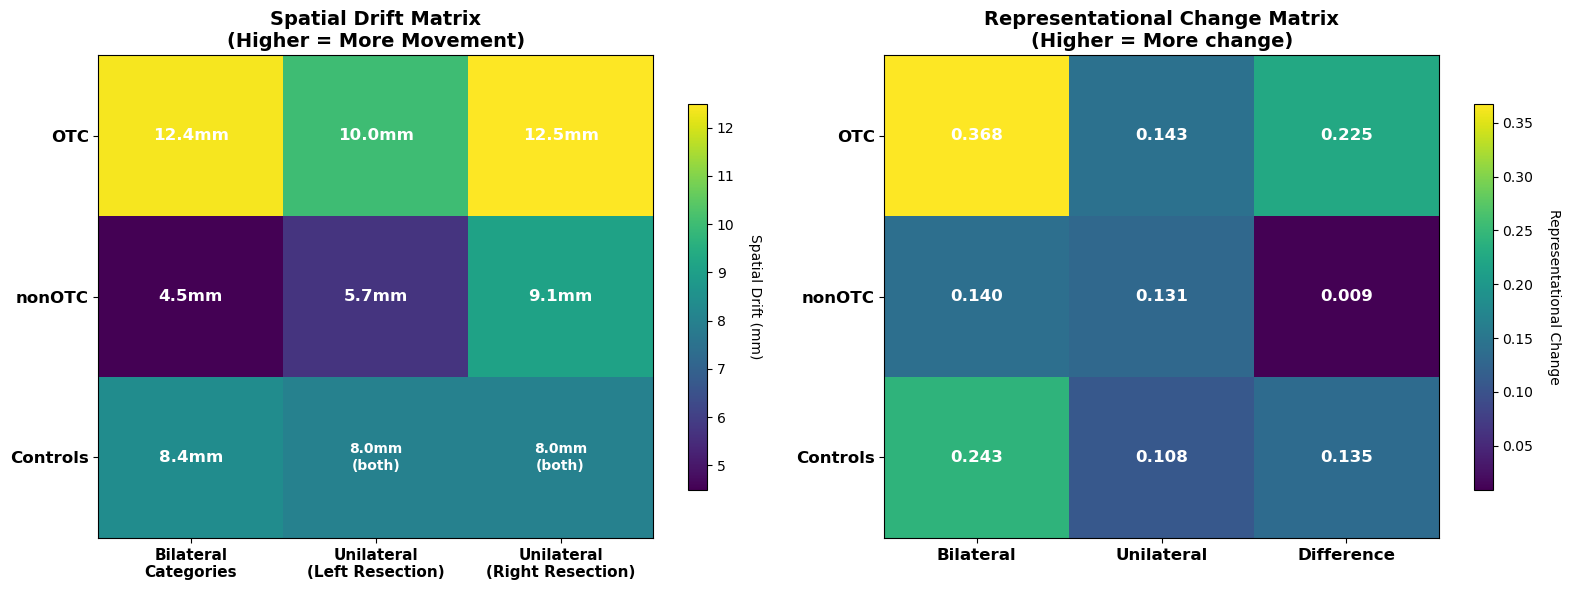


2. Hemisphere × Category Matrices


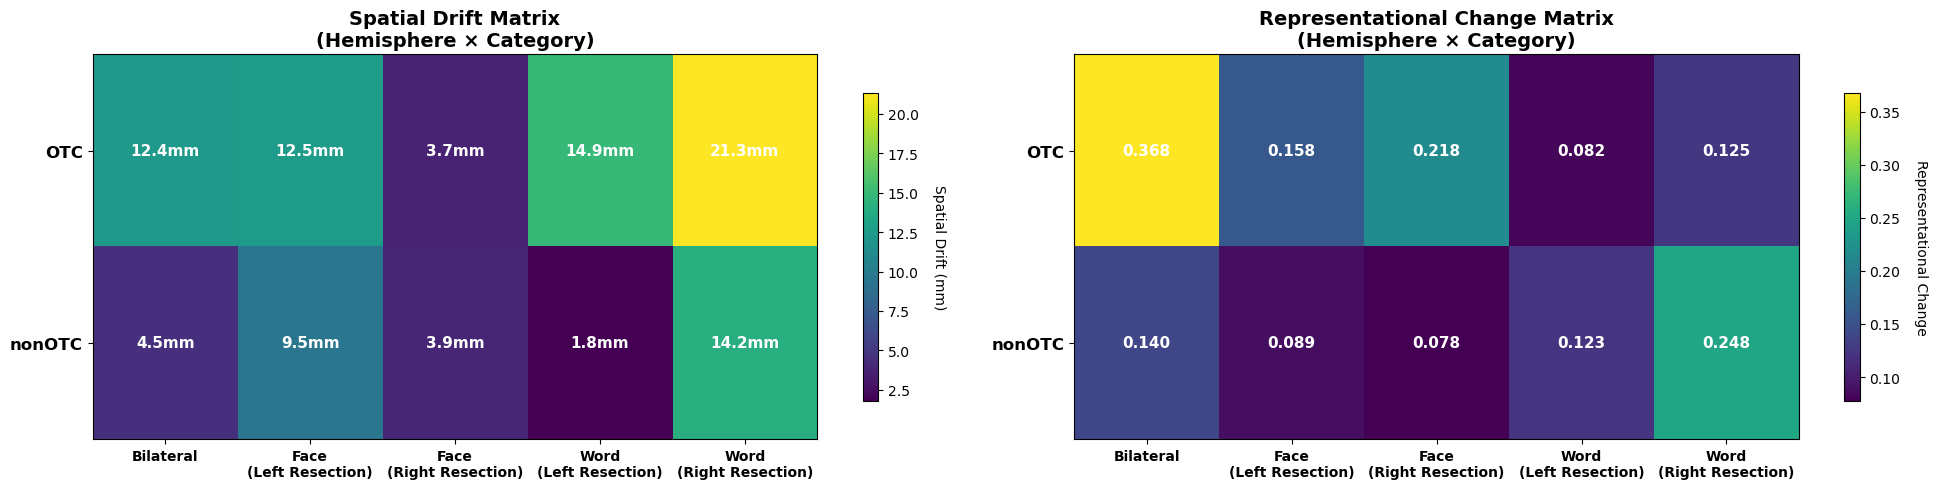


HEMISPHERE × CATEGORY SUMMARY:

OTC:
  Bilateral: spatial=12.4mm, repr=0.368
  Face (Left resection): spatial=12.5mm, repr=0.158
  Face (Right resection): spatial=3.7mm, repr=0.218
  Word (Left resection): spatial=14.9mm, repr=0.082
  Word (Right resection): spatial=21.3mm, repr=0.125

nonOTC:
  Bilateral: spatial=4.5mm, repr=0.140
  Face (Left resection): spatial=9.5mm, repr=0.089
  Face (Right resection): spatial=3.9mm, repr=0.078
  Word (Left resection): spatial=1.8mm, repr=0.123
  Word (Right resection): spatial=14.2mm, repr=0.248

3. Topography with Drift Circles


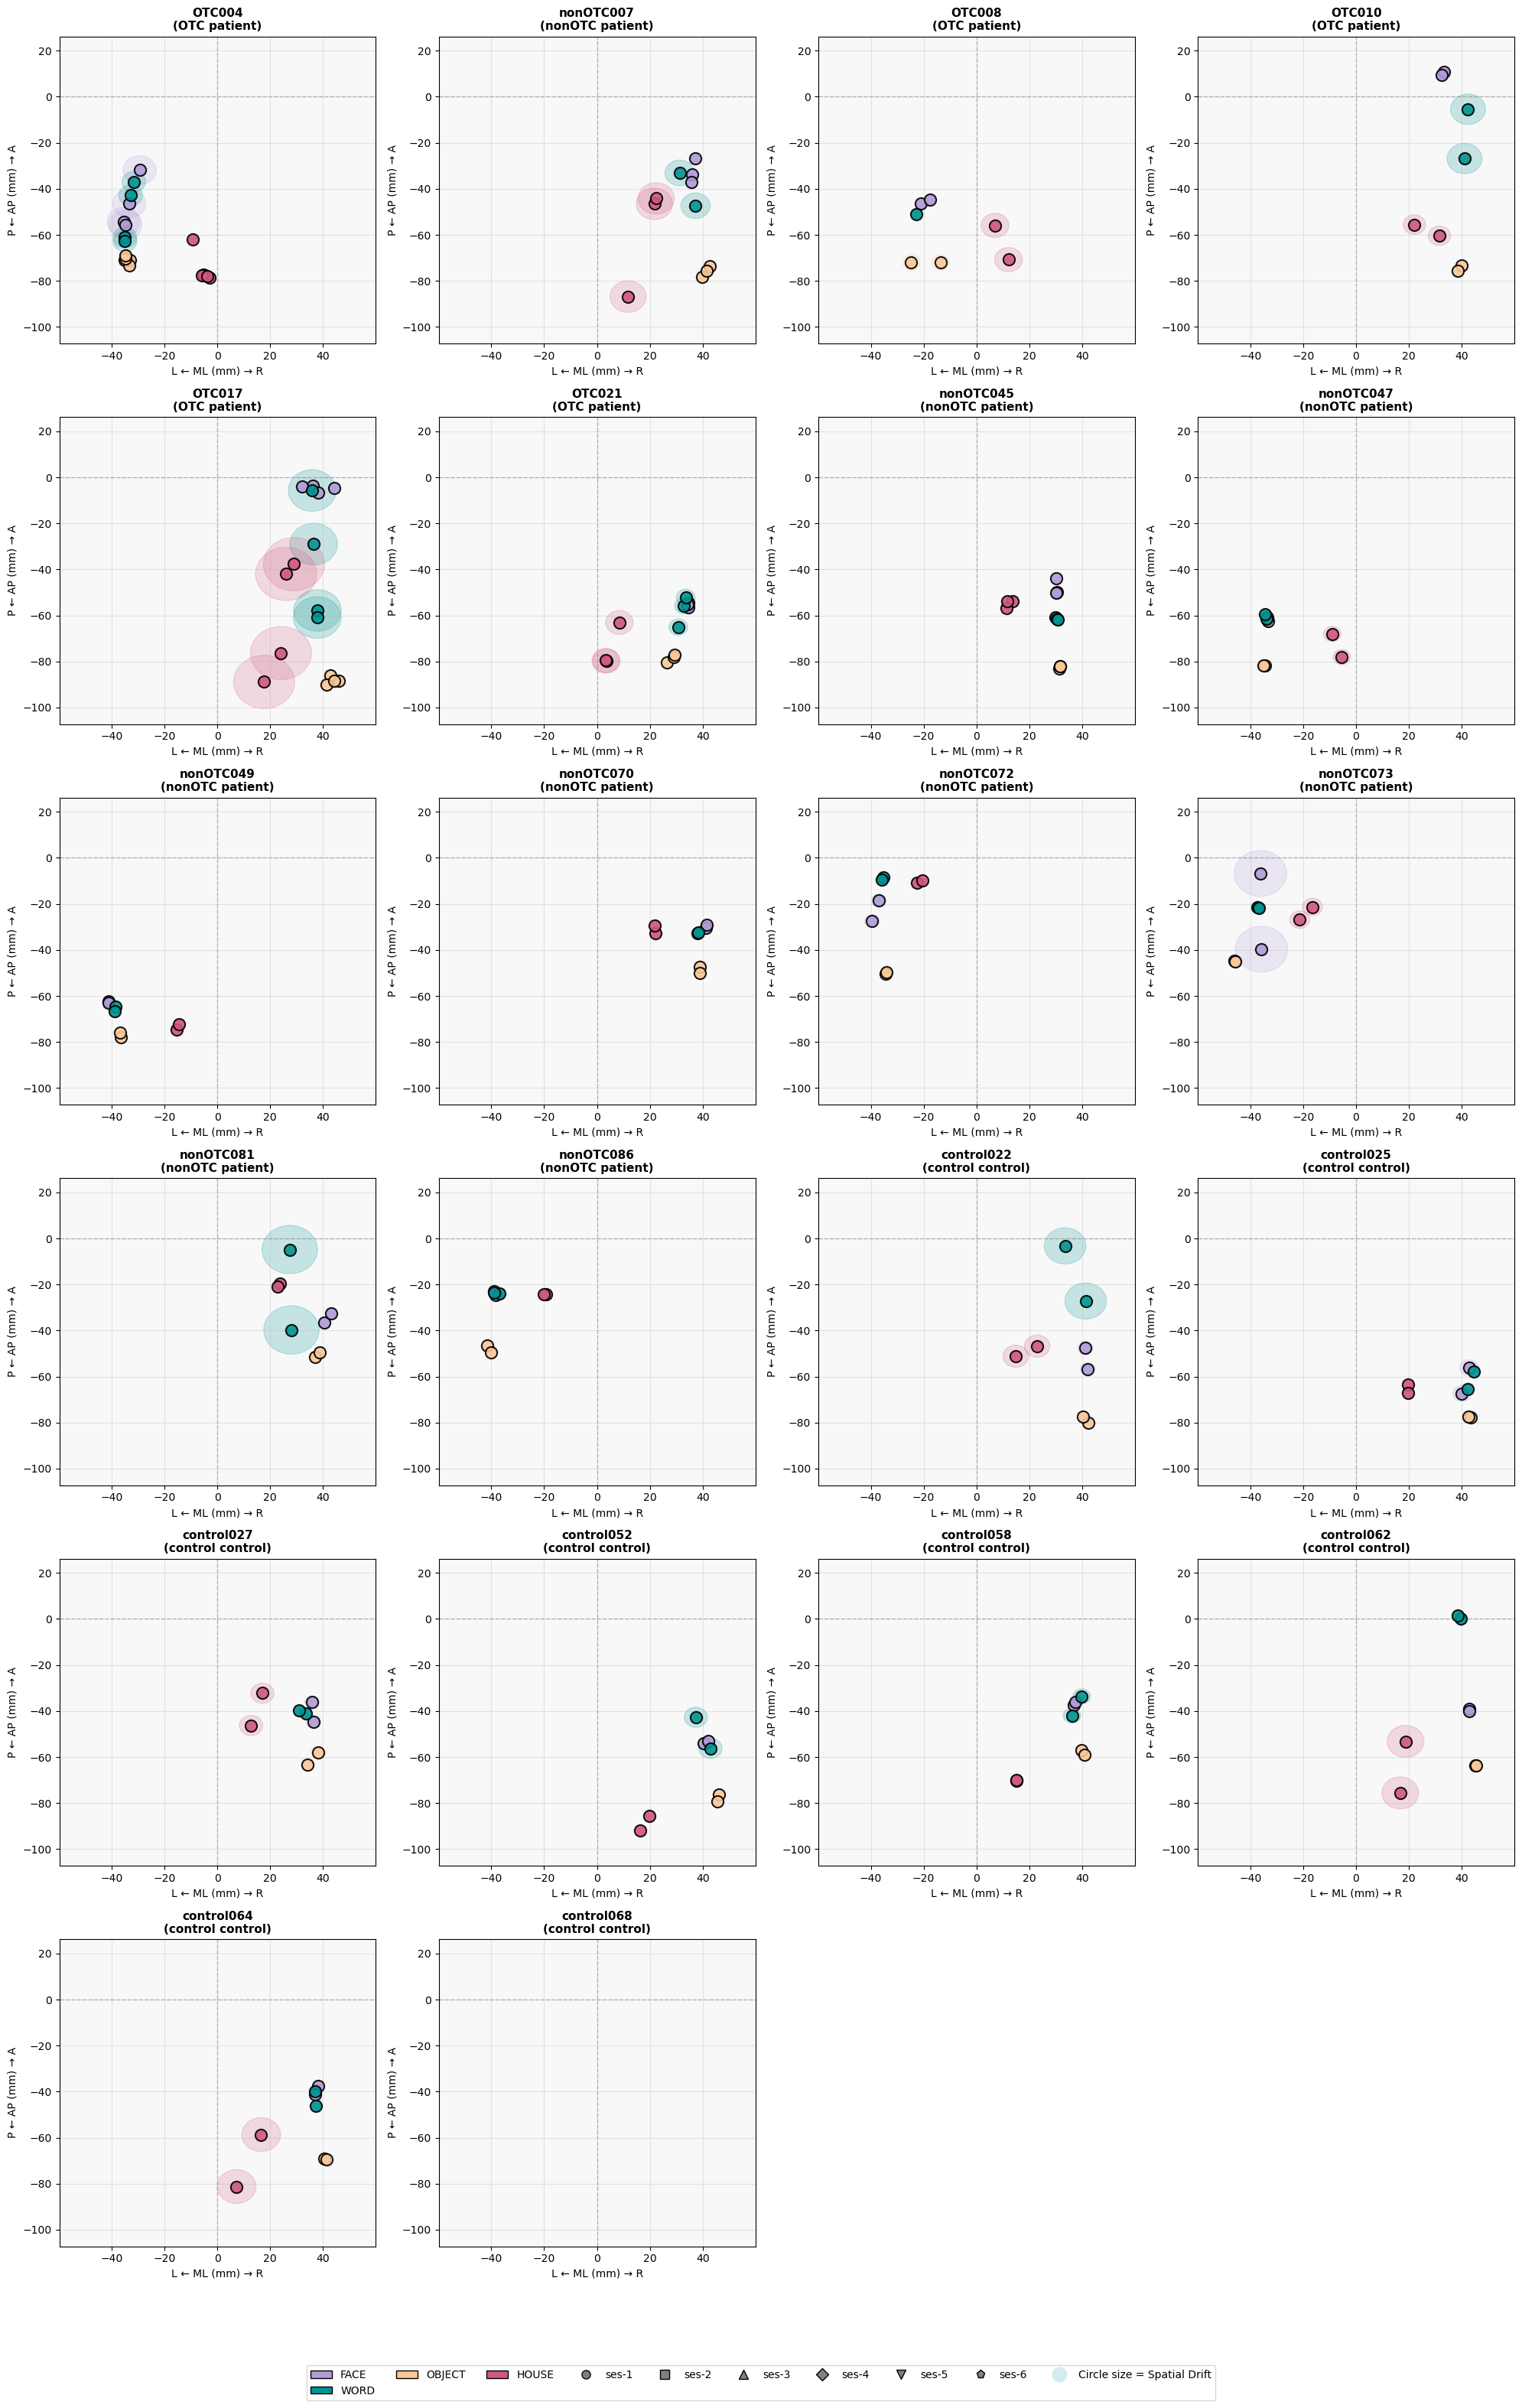


4. OTC Patient Timelines
OTC PATIENT TIMELINES FOR CONTROL MATCHING


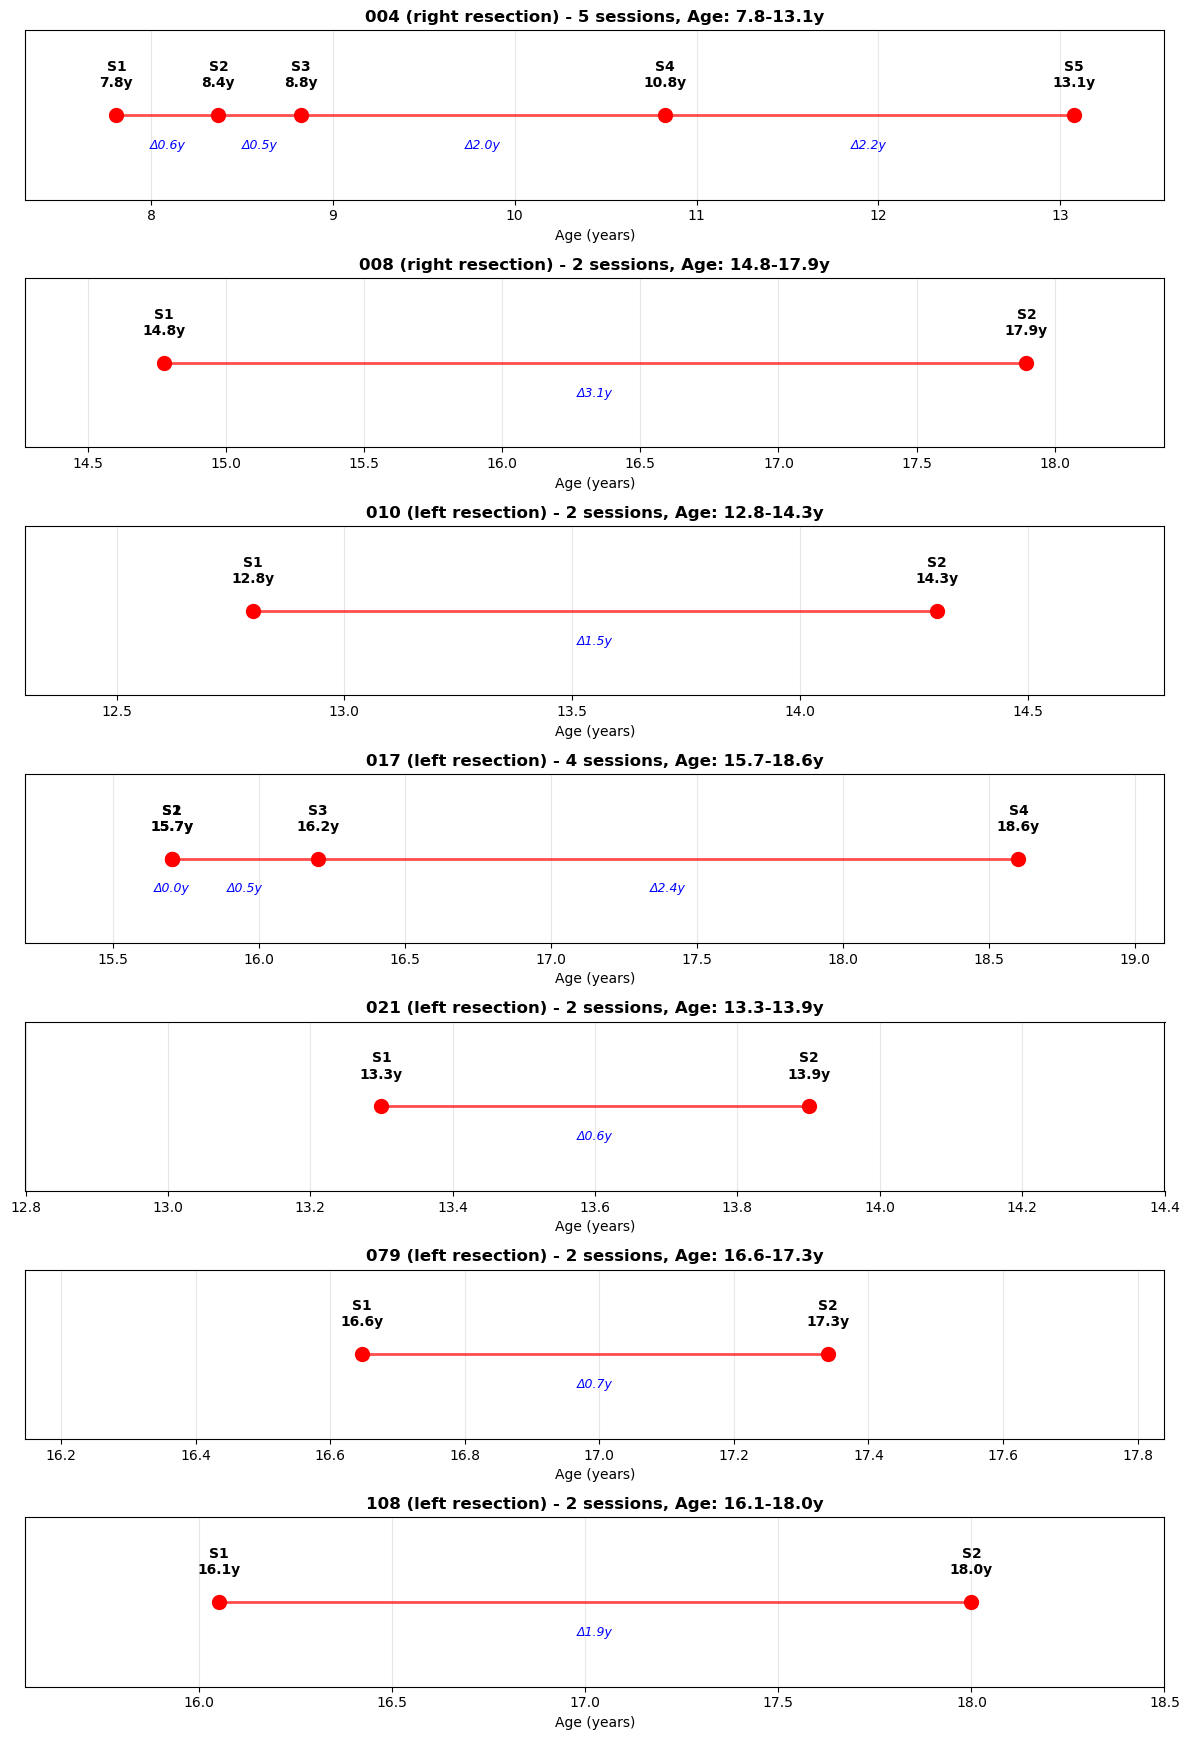


✓ All visualizations complete!


In [16]:
# CELL 7: Execute Visualizations
print("CREATING FINAL VISUALIZATIONS")
print("="*50)

# 1. Core matrix plots showing main findings
print("\n1. Bilateral vs Unilateral Matrices")
plot_matrices()

# 2. Hemisphere-specific matrices (NEW!)
print("\n2. Hemisphere × Category Matrices")
spatial_matrix, repr_matrix = plot_hemisphere_matrices(complete_hemisphere_results)

# 3. Topography plot showing spatial drift
print("\n3. Topography with Drift Circles")
plot_topography(functional_rois, ANALYSIS_SUBJECTS, results_table)

# 4. OTC timeline for control matching
print("\n4. OTC Patient Timelines")
timeline_data = plot_timelines()

print("\n✓ All visualizations complete!")

In [17]:
# CELL 8: Summary and Results Table
print("FINAL RESULTS SUMMARY")
print("="*50)

# Display key findings
print("\n🔑 KEY FINDINGS:")
print("1. Bilateral categories show greater representational change than unilateral categories across ALL groups")
print("2. OTC patients show strongest bilateral plasticity (+0.225 difference)")
print("3. Spatial drift follows hemisphere-specific patterns:")
print("   • Face processing: more drift with left resection")
print("   • Word processing: more drift with right resection")

# Show sample of results table
print("\n📊 RESULTS TABLE (Sample):")
sample_table = results_table.groupby(['Group', 'Category_Type']).agg({
    'Spatial_Drift_mm': 'mean',
    'Representational_Change': 'mean',
    'Subject': 'count'
}).round(3)
sample_table.columns = ['Spatial_Drift_mm', 'Repr_Change', 'N_observations']
print(sample_table)

print("\n✅ STREAMLINED RSA ANALYSIS COMPLETE!")
print(f"\n📈 Analyzed {len(results_table)} data points from {len(ANALYSIS_SUBJECTS)} subjects")
print(f"📂 Results saved to: {OUTPUT_DIR}")

FINAL RESULTS SUMMARY

🔑 KEY FINDINGS:
1. Bilateral categories show greater representational change than unilateral categories across ALL groups
2. OTC patients show strongest bilateral plasticity (+0.225 difference)
3. Spatial drift follows hemisphere-specific patterns:
   • Face processing: more drift with left resection
   • Word processing: more drift with right resection

📊 RESULTS TABLE (Sample):
                       Spatial_Drift_mm  Repr_Change  N_observations
Group   Category_Type                                               
OTC     Bilateral                12.416        0.368              10
        Unilateral               12.786        0.159               9
control Bilateral                 8.399        0.243              14
        Unilateral                8.001        0.108              14
nonOTC  Bilateral                 4.541        0.140              18
        Unilateral                7.143        0.131              18

✅ STREAMLINED RSA ANALYSIS COMPLETE!

📈 A